# Veteran Population Cleaning and Exploration
---
Now we really start digging into the data


In [1]:
# importing necessary libraries for EDA
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import missingno as ms

## Compressed 1 yr Data Import
---


In [2]:
# read in data
pop_1 = pd.read_csv("../veteran_population_-analysis/working_data/us_pop_1yr_compressed.csv")
vets_1 = pd.read_csv("../veteran_population_-analysis/working_data/vets_1yr_compressed.csv")

In [3]:
'''Additional viewing options'''
# This code sets the notebook to display maximum columns.  Uncomment it to see trunacted view
pd.set_option('display.max_columns', len(pop_1))  

# This resets the view to a truncated output
#pd.reset_option('display.max_rows')   

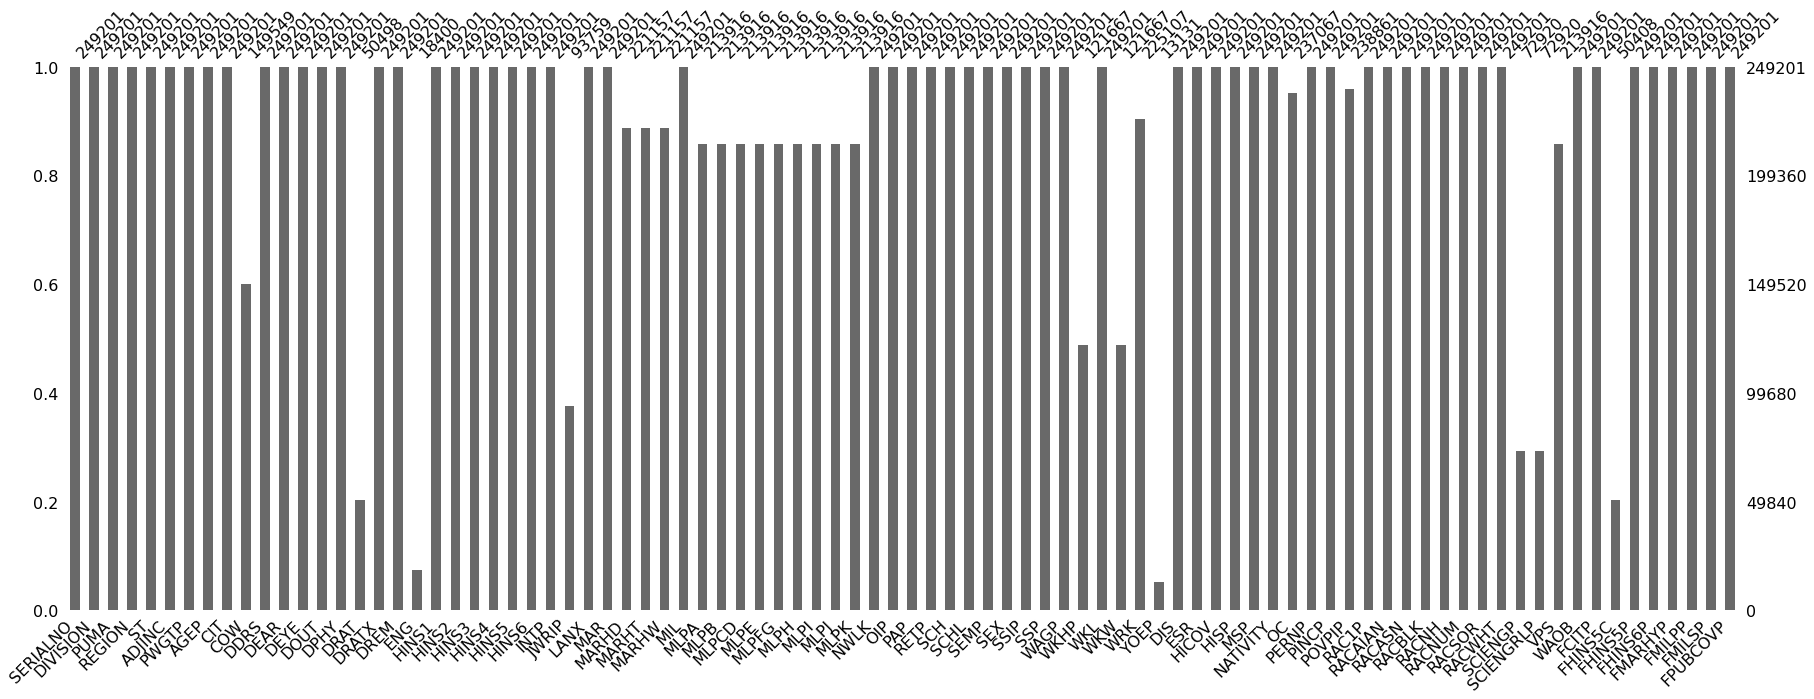

In [4]:
ms.bar(vets_1, labels=True, figsize=(30,10));

### Data Cleaning
---
PUMs is a pretty clean dataset.  However, there are several variables that need to be combined in order to be useful.  For instance, the ADINC feature needs to multiplied to INTP to read it in current dollars.

T

In [5]:
# In this next s
def data_cleaner(df):
    start = time.time() 
    
    #Inflation adjustment
    df.insert(1, 'INTP_adj', df['INTP'] * (df['ADJINC']/1000000))                
    df.insert(1, 'OIP_adj', df['OIP'] * (df['ADJINC']/1000000))
    df.insert(1, 'PAP_adj', df['PAP'] * (df['ADJINC']/1000000))
    df.insert(1, 'RETP_adj', df['RETP'] * (df['ADJINC']/1000000))
    df.insert(1, 'SSP_adj', df['SSIP'] * (df['ADJINC']/1000000))
    df.insert(1, 'SSIP_adj', df['SSIP'] * (df['ADJINC']/1000000))
    df.insert(1, 'WAGP_adj', df['WAGP'] * (df['ADJINC']/1000000))
    df.insert(1, 'PERNP_adj', df['PERNP'] * (df['ADJINC']/1000000))
    df.insert(1, 'PINCP_adj', df['PINCP'] * (df['ADJINC']/1000000))
    df.insert(1, 'SEMP_adj', df['SEMP'] * (df['ADJINC']/1000000))
    
    #Treat Nulls
    df['COW'].fillna(9)                  # this recodes nulls to 9 which is a similar categorization
    df['DRAT'] = df['DRAT'].replace({6:-99}) # a 6 in this column is actually a null or not reported response
    df['DRAT'].fillna(6)                 # now using recoding nulls to 6 for no service connected disability
    df['ENG'].fillna(1)                  # NULLs = speaks only english...combining with 1 = Speaks very well
    df['MARHD'].fillna(0)                # NULLS = never married changing to zero
    df.drop(df[df['MARHD'] == 8].index, inplace = True)  # Certain PUMAs suppressed data, therefore dropping rows if suppressed
    df['MARHT'].fillna(0)                # NULLS = never married changing to zero
    df['MARHW'].fillna(0)                # NULLS = never married changing to zero
    df['WKHP'].fillna(0)                 # NULL indicates not working in last 12 months.  Recoding to zero.
    df.drop(df[df['POVPIP'] == np.NaN].index, inplace = True) #There are small number of nulls and this value is difficult to impute
    df['SCIENGP'].fillna(0)              #NULL indicates individual has less than Bachelor's. No STEM degree.
    df['SCIENGRLP'].fillna(0)            #NULL indicates individual has less than Bachelor's. No STEM related degree.
    df['VPS'].fillna(0)                  # Recoding "Never served Active Duty" to zero
    df['NWLK'].fillna(0)                 # NULLS= at work
    
    # Modify features so One Hot Encoding makes more sense
    df['JWRIP'] = df['JWRIP'].map({np.NaN:0, 1:1, 2:2, 3:2, 4:2, 5:2, 6:2, 
                                   7:2, 8:2, 9:2, 10:2}).fillna(df['JWRIP'])  # Recoding: no vehicle=0, drive alone=1, carpool=2
    df['MAR'] = df['MAR'].map({5:0}).fillna(df['MAR'])         # Recoding "never married" to zero
    df['MIL'] = df['MIL'].map({4:0}).fillna(df['MIL'])         # Recoding "Never served in military" to zero
    df['NWLK'] = df['NWLK'].map({3:-99}).fillna(df['NWLK'])    # Recoding "Not reported" to negative one as a proxy for null
    df['WKL'] = df['WKL'].map({3:0}).fillna(df['WKL'])         # Recoding "Never worked or over 5 years ago" to zero
    df['ESR'] = df['ESR'].map({6:0}).fillna(df['ESR'])         # Recoding "Not in workforce" to zero
    df['HISP'] = df['HISP'].map({1:0, 2:1, 3:1, 4:1, 5:1,      # Recoding so 0 = not HISP and 1 = HISP
                                 6:1, 7:1, 8:1, 9:1, 10:1, 
                                 11:1, 12:1, 13:1, 14:1, 15:1, 
                                 16:1, 17:1, 18:1, 19:1, 20:1, 
                                 21:1, 22:1, 23:1, 24:1}).fillna(df['HISP'])
    df['MSP'] = df['MSP'].map({6:0}).fillna(df['MSP'])                      # Recoding "never married" to zero
    df['NATIVITY'] = df['NATIVITY'].map({2:0}).fillna(df['NATIVITY'])       # Recoding "foreign born" to zero
    df['SCIENGP'] = df['SCIENGP'].map({2:0}).fillna(df['SCIENGP'])          # Recoding "No Science degree" to zero
    df['SCIENGRLP'] = df['SCIENGRLP'].map({2:0}).fillna(df['SCIENGRLP'])    # Recoding "No Science related degree" to zero
    
    # Recode remaining nulls
    df = df.fillna(-99)
    
    #During import some columns were mistakenly coded as floats.  This will reset them to integers
    floats = ['COW', 'DDRS', 'DOUT', 'DPHY', 'DRAT', 'DRATX', 'DREM', 'ENG', 'JWRIP', 'LANX', 'MARHD', 'MAR', 'MARHT',
             'MARHW', 'MIL', 'MLPA', 'MLPB', 'MLPCD', 'MLPE', 'MLPFG', 'MLPH', 'MLPI', 'MLPJ', 'MLPK', 'NWLK',
             'PAP', 'SCH', 'SCHL', 'WKL', 'WRK', 'ESR', 'MSP', 'OC', 'SCIENGP', 'SCIENGRLP', 'VPS', 'FHINS5C', 'WKW']
    df[floats] = df[floats].astype(int)     
    
    
     # Drop unadjusted columns.  They are redundant now.
    df = df.drop(columns=df[['INTP', 'OIP', 'PAP', 'RETP', 'SSIP', 'SSP', 'WAGP', 'PERNP', 'PINCP', 'YOEP', 'SEMP']])
    
    end = time.time()
    print('total time (s)= ' + str(end-start))
    return df

In [6]:
def one_hot(df):  
    # Identify columns to encode
    cols = ['REGION', 'DIVISION','CIT',            
            'COW', 'DEAR', 'DEYE', 'WKW',
            'DOUT', 'DPHY', 'DRAT', 'RAC1P',
            'DRATX', 'DREM', 'ENG', 'MLPK',
            'HINS1', 'HINS2', 'MLPB', 'MLPCD',               
            'HINS3', 'HINS4', 'HINS5', 'HINS6',
            'JWRIP', 'LANX', 'MAR', 'MARHD',         # for later 'ST', 'SCHL'(somewhat heirarchical)
            'MARHT', 'MARHW', 'MIL', 'MLPA', 
            'MLPE', 'MLPFG', 'MLPH', 'MLPI', 
            'NWLK', 'SCH', 'SCHL', 'SEX', 'WRK',    # HICOV reveals if there is any health coverage or not
            'MSP', 'VPS', 'ESR', 'HICOV', 'MLPJ']
    
    # Put columns in seperate dataframe for concatenation after encoding complete
    original = pd.DataFrame(df[cols])
    
    # One Hot Encode certain features
    test_dum = pd.get_dummies(data=df, columns=cols, 
                              drop_first=True, dtype=int)
    
    df = pd.concat([original, test_dum], axis=1);

    return df

In [7]:
pop_1 = data_cleaner(pop_1)
pop_1.head()

total time (s)= 34.71038317680359


,SERIALNO,SEMP_adj,PINCP_adj,PERNP_adj,WAGP_adj,SSIP_adj,SSP_adj,RETP_adj,PAP_adj,OIP_adj,INTP_adj,DIVISION,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,CIT,COW,DDRS,DEAR,DEYE,DOUT,DPHY,DRAT,DRATX,DREM,ENG,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,JWRIP,LANX,MAR,MARHD,MARHT,MARHW,MIL,MLPA,MLPB,MLPCD,MLPE,MLPFG,MLPH,MLPI,MLPJ,MLPK,NWLK,SCH,SCHL,SEX,WKHP,WKL,WKW,WRK,DIS,ESR,HICOV,HISP,MSP,NATIVITY,OC,POVPIP,RAC1P,RACAIAN,RACASN,RACBLK,RACNH,RACNUM,RACSOR,RACWHT,SCIENGP,SCIENGRLP,VPS,WAOB,FCITP,FHINS5C,FHINS5P,FHINS6P,FMARHYP,FMILPP,FMILSP,FPUBCOVP
0,2018GQ0000049,0.0,-1519.6455,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,-1519.6455,6,1600,3,1,1013097,75,19,1,1,2,2,2,2,2,-99,-99,2,-99,1,2,2,2,2,2,0,2,0,-99,-99,-99,0,-99,-99,-99,-99,-99,-99,-99,-99,-99,2,2,18,2,-99.0,2,-99,2,2,0,1,0,0,1.0,-99,-99.0,1,0,0,0,0,1,0,1,-99,-99,-99,1,0,-99,0,0,0,0,0,0
1,2018GQ0000058,0.0,1620.9552,1620.9552,1620.9552,0.0,0.0,0.0,0.0,0.0,0.0000,6,1900,3,1,1013097,75,18,1,1,2,2,2,2,2,-99,-99,2,-99,1,2,2,2,2,2,0,2,0,-99,-99,-99,0,-99,-99,-99,-99,-99,-99,-99,-99,-99,2,2,18,2,21.0,1,6,2,2,0,1,0,0,1.0,-99,-99.0,2,0,0,1,0,1,0,0,-99,-99,-99,1,0,-99,0,0,0,0,0,0
2,2018GQ0000219,0.0,10130.9700,10130.9700,10130.9700,0.0,0.0,0.0,0.0,0.0,0.0000,6,2000,3,1,1013097,118,53,1,5,2,2,2,2,2,-99,-99,1,2,2,2,2,2,2,2,0,1,0,-99,-99,-99,0,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,1,17,1,40.0,1,1,1,1,0,2,1,0,1.0,-99,-99.0,1,0,0,0,0,1,0,1,-99,-99,-99,1,0,-99,0,0,0,0,0,0
3,2018GQ0000246,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,6,2400,3,1,1013097,43,28,1,-99,2,2,2,2,2,-99,2,2,-99,2,2,2,2,2,2,0,2,0,-99,-99,-99,2,1,0,0,0,0,0,0,0,0,-99,1,19,1,-99.0,0,-99,-99,2,0,2,0,0,1.0,-99,-99.0,1,0,0,0,0,1,0,1,-99,-99,1,1,0,-99,0,0,0,0,0,0
4,2018GQ0000251,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,6,2701,3,1,1013097,16,25,1,1,2,2,2,2,2,-99,-99,1,-99,1,2,2,2,2,2,0,2,0,-99,-99,-99,0,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,1,12,2,-99.0,2,-99,-99,1,0,1,0,0,1.0,-99,-99.0,1,0,0,0,0,1,0,1,-99,-99,-99,1,0,-99,0,0,0,0,0,0


In [8]:
# Saving version for Tableau processing
pop_1.to_csv('./tableau_data/us_pop_1yr_tableau.csv', index=False)

In [9]:
pop_1 = one_hot(pop_1)
pop_1.head()

,REGION,DIVISION,CIT,COW,DEAR,DEYE,WKW,DOUT,DPHY,DRAT,RAC1P,DRATX,DREM,ENG,MLPK,HINS1,HINS2,MLPB,MLPCD,HINS3,HINS4,HINS5,HINS6,JWRIP,LANX,MAR,MARHD,MARHT,MARHW,MIL,MLPA,MLPE,MLPFG,MLPH,MLPI,NWLK,SCH,SCHL,SEX,WRK,MSP,VPS,ESR,HICOV,MLPJ,SERIALNO,SEMP_adj,PINCP_adj,PERNP_adj,WAGP_adj,SSIP_adj,SSP_adj,RETP_adj,PAP_adj,OIP_adj,INTP_adj,PUMA,ST,ADJINC,PWGTP,AGEP,DDRS,WKHP,WKL,DIS,HISP,NATIVITY,OC,POVPIP,RACAIAN,RACASN,RACBLK,RACNH,RACNUM,RACSOR,RACWHT,SCIENGP,SCIENGRLP,WAOB,FCITP,FHINS5C,FHINS5P,FHINS6P,FMARHYP,FMILPP,FMILSP,FPUBCOVP,REGION_2,REGION_3,REGION_4,DIVISION_2,DIVISION_3,DIVISION_4,DIVISION_5,DIVISION_6,DIVISION_7,DIVISION_8,DIVISION_9,CIT_2,CIT_3,CIT_4,CIT_5,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,COW_8,COW_9,DEAR_2,DEYE_2,WKW_1,WKW_2,WKW_3,WKW_4,WKW_5,WKW_6,DOUT_2,DPHY_2,DRAT_1,DRAT_2,DRAT_3,DRAT_4,DRAT_5,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,DRATX_1,DRATX_2,DREM_2,ENG_1,ENG_2,ENG_3,ENG_4,MLPK_0,MLPK_1,HINS1_2,HINS2_2,MLPB_0,MLPB_1,MLPCD_0,MLPCD_1,HINS3_2,HINS4_2,HINS5_2,HINS6_2,JWRIP_1,JWRIP_2,LANX_2,MAR_1,MAR_2,MAR_3,MAR_4,MARHD_1,MARHD_2,MARHT_1,MARHT_2,MARHT_3,MARHW_1,MARHW_2,MIL_1,MIL_2,MIL_3,MLPA_0,MLPA_1,MLPE_0,MLPE_1,MLPFG_0,MLPFG_1,MLPH_0,MLPH_1,MLPI_0,MLPI_1,NWLK_1,NWLK_2,SCH_2,SCH_3,SCHL_2,SCHL_3,SCHL_4,SCHL_5,SCHL_6,SCHL_7,SCHL_8,SCHL_9,SCHL_10,SCHL_11,SCHL_12,SCHL_13,SCHL_14,SCHL_15,SCHL_16,SCHL_17,SCHL_18,SCHL_19,SCHL_20,SCHL_21,SCHL_22,SCHL_23,SCHL_24,SEX_2,WRK_1,WRK_2,MSP_1,MSP_2,MSP_3,MSP_4,MSP_5,VPS_1,VPS_2,VPS_3,VPS_4,VPS_5,VPS_6,VPS_7,VPS_8,VPS_9,VPS_10,VPS_11,VPS_12,VPS_13,VPS_14,VPS_15,ESR_1,ESR_2,ESR_3,ESR_4,ESR_5,HICOV_2,MLPJ_0,MLPJ_1
0,3,6,1,1,2,2,-99,2,2,-99,1,-99,2,-99,-99,1,2,-99,-99,2,2,2,2,0,2,0,-99,-99,-99,0,-99,-99,-99,-99,-99,2,2,18,2,2,0,-99,0,1,-99,2018GQ0000049,0.0,-1519.6455,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,-1519.6455,1600,1,1013097,75,19,2,-99.0,2,2,0,1.0,-99,-99.0,0,0,0,0,1,0,1,-99,-99,1,0,-99,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3,6,1,1,2,2,6,2,2,-99,2,-99,2,-99,-99,1,2,-99,-99,2,2,2,2,0,2,0,-99,-99,-99,0,-99,-99,-99,-99,-99,2,2,18,2,2,0,-99,0,1,-99,2018GQ0000058,0.0,1620.9552,1620.9552,1620.9552,0.0,0.0,0.0,0.0,0.0,0.0000,1900,1,1013097,75,18,2,21.0,1,2,0,1.0,-99,-99.0,0,0,1,0,1,0,0,-99,-99,1,0,-99,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,6,1,5,2,2,1,2,2,-99,1,-99,1,2,-99,2,2,-99,-99,2,2,2,2,0,1,0,-99,-99,-99,0,-99,-99,-99,-99,-99,-99,1,17,1,1,0,-99,0,2,-99,2018GQ0000219,0.0,10130.9700,10130.9700,10130.9700,0.0,0.0,0.0,0.0,0.0,0.0000,2000,1,1013097,118,53,2,40.0,1,1,1,1.0,-99,-99.0,0,0,0,0,1,0,1,-99,-99,1,0,-99,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,3,6,1,-99,2,2,-99,2,2,-99,1,2,2,-99,0,2,2,0,0,2,2,2,2,0,2,0,-99,-99,-99,2,1,0,0,0,0,-99,1,19,1,-99,0,1,0,2,0,2018GQ0000246,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,2400,1,1013097,43,28,2,-99.0,0,2,0,1.0,-99,-99.0,0,0,0,0,1,0,1,-99,-99,1,0,-99,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,1,0,1,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,3,6,1,1,2,2,-99,2,2,-99,1,

In [10]:
vets_1 = data_cleaner(vets_1)
vets_1.info()

total time (s)= 2.4490039348602295
<class 'pandas.core.frame.DataFrame'>
Int64Index: 248859 entries, 0 to 249200
Data columns (total 87 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   SERIALNO   248859 non-null  object 
 1   SEMP_adj   248859 non-null  float64
 2   PINCP_adj  248859 non-null  float64
 3   PERNP_adj  248859 non-null  float64
 4   WAGP_adj   248859 non-null  float64
 5   SSIP_adj   248859 non-null  float64
 6   SSP_adj    248859 non-null  float64
 7   RETP_adj   248859 non-null  float64
 8   PAP_adj    248859 non-null  float64
 9   OIP_adj    248859 non-null  float64
 10  INTP_adj   248859 non-null  float64
 11  DIVISION   248859 non-null  int64  
 12  PUMA       248859 non-null  int64  
 13  REGION     248859 non-null  int64  
 14  ST         248859 non-null  int64  
 15  ADJINC     248859 non-null  int64  
 16  PWGTP      248859 non-null  int64  
 17  AGEP       248859 non-null  int64  
 18  CIT        248859 non-null  i

In [11]:
# Saving version for Tableau processing
vets_1.to_csv('./tableau_data/vets_1yr_tableau.csv', index=False)

In [12]:
vets_1 = one_hot(vets_1)
vets_1.head()

,REGION,DIVISION,CIT,COW,DEAR,DEYE,WKW,DOUT,DPHY,DRAT,RAC1P,DRATX,DREM,ENG,MLPK,HINS1,HINS2,MLPB,MLPCD,HINS3,HINS4,HINS5,HINS6,JWRIP,LANX,MAR,MARHD,MARHT,MARHW,MIL,MLPA,MLPE,MLPFG,MLPH,MLPI,NWLK,SCH,SCHL,SEX,WRK,MSP,VPS,ESR,HICOV,MLPJ,SERIALNO,SEMP_adj,PINCP_adj,PERNP_adj,WAGP_adj,SSIP_adj,SSP_adj,RETP_adj,PAP_adj,OIP_adj,INTP_adj,PUMA,ST,ADJINC,PWGTP,AGEP,DDRS,WKHP,WKL,DIS,HISP,NATIVITY,OC,POVPIP,RACAIAN,RACASN,RACBLK,RACNH,RACNUM,RACSOR,RACWHT,SCIENGP,SCIENGRLP,WAOB,FCITP,FHINS5C,FHINS5P,FHINS6P,FMARHYP,FMILPP,FMILSP,FPUBCOVP,REGION_2,REGION_3,REGION_4,DIVISION_2,DIVISION_3,DIVISION_4,DIVISION_5,DIVISION_6,DIVISION_7,DIVISION_8,DIVISION_9,CIT_2,CIT_3,CIT_4,CIT_5,COW_1,COW_2,COW_3,COW_4,COW_5,COW_6,COW_7,COW_8,COW_9,DEAR_2,DEYE_2,WKW_1,WKW_2,WKW_3,WKW_4,WKW_5,WKW_6,DOUT_2,DPHY_2,DRAT_1,DRAT_2,DRAT_3,DRAT_4,DRAT_5,RAC1P_2,RAC1P_3,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,DRATX_2,DREM_2,ENG_1,ENG_2,ENG_3,ENG_4,MLPK_0,MLPK_1,HINS1_2,HINS2_2,MLPB_0,MLPB_1,MLPCD_0,MLPCD_1,HINS3_2,HINS4_2,HINS5_2,HINS6_2,JWRIP_1,JWRIP_2,LANX_2,MAR_1,MAR_2,MAR_3,MAR_4,MARHD_1,MARHD_2,MARHT_1,MARHT_2,MARHT_3,MARHW_1,MARHW_2,MIL_2,MIL_3,MLPA_0,MLPA_1,MLPE_0,MLPE_1,MLPFG_0,MLPFG_1,MLPH_0,MLPH_1,MLPI_0,MLPI_1,NWLK_1,NWLK_2,SCH_2,SCH_3,SCHL_2,SCHL_3,SCHL_4,SCHL_5,SCHL_6,SCHL_7,SCHL_8,SCHL_9,SCHL_10,SCHL_11,SCHL_12,SCHL_13,SCHL_14,SCHL_15,SCHL_16,SCHL_17,SCHL_18,SCHL_19,SCHL_20,SCHL_21,SCHL_22,SCHL_23,SCHL_24,SEX_2,WRK_1,WRK_2,MSP_1,MSP_2,MSP_3,MSP_4,MSP_5,VPS_1,VPS_2,VPS_3,VPS_4,VPS_5,VPS_6,VPS_7,VPS_8,VPS_9,VPS_10,VPS_11,VPS_12,VPS_13,VPS_14,VPS_15,ESR_1,ESR_2,ESR_3,ESR_4,ESR_5,HICOV_2,MLPJ_0,MLPJ_1
0,3,6,1,-99,2,2,-99,2,2,-99,1,2,2,-99,0,2,2,0,0,2,2,2,2,0,2,0,-99,-99,-99,2,1,0,0,0,0,-99,1,19,1,-99,0,1,0,2,0,2018GQ0000246,0.0,0.0000,0.000,0.000,0.000,0.000,0.0,0.0,0.0000,0.0,2400,1,1013097,43,28,2,-99.0,0,2,0,1.0,-99,-99.0,0,0,0,0,1,0,1,-99,-99,1,0,-99,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,1,0,1,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,3,6,4,-99,1,2,-99,1,1,2,8,1,1,-99,0,2,2,0,1,2,2,2,2,0,2,4,2,1,2,2,0,0,0,0,0,2,1,19,1,2,5,12,0,2,0,2018GQ0001284,0.0,1418.3358,0.000,0.000,0.000,0.000,0.0,0.0,1418.3358,0.0,1303,1,1013097,16,57,1,-99.0,0,1,1,0.0,-99,10.0,0,0,0,0,1,1,0,-99,-99,3,0,-99,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
2,3,6,1,5,2,2,1,2,2,-99,1,2,2,-99,0,2,2,0,0,2,2,1,2,0,2,0,-99,-99,-99,1,1,0,0,0,0,-99,1,19,1,1,0,1,4,1,0,2018GQ0001685,0.0,29379.8130,29379.813,29379.813,0.000,0.000,0.0,0.0,0.0000,0.0,2500,1,1013097,68,21,2,50.0,1,2,1,1.0,-99,-99.0,0,0,0,0,1,0,1,-99,-99,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,3,6,1,-99,1,1,-99,1,1,-99,1,2,1,-99,0,2,2,0,0,1,1,2,2,0,2,0,-99,-99,-99,2,0,1,0,0,0,-99,1,15,1,-99,0,6,0,1,0,2018GQ0004346,0.0,6078.5820,0.000,0.000,6078.582,6078.582,0.0,0.0,0.0000,0.0,1301,1,1013097,8,69,1,-99.0,0,1,0,1.0,-99,-99.0,0,0,0,0,1,0,1,-99,-99,1,0,-99,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,3,6,1,5,2,2,1,2,2,-99,2,2,2,-99,0,1,2,0,0,2,2,1,2,0,2,0,-99,-99,-99,1,1,0,0,0,0,-99,1,18,1,1,0,1,4,1,0,2018GQ000489

In [13]:
#Saving cleaned version
pop_1.to_csv('./working_data/us_pop_1yr_clean.csv', index=False)
vets_1.to_csv('./working_data/vets_1yr_clean.csv', index=False)

## 5yr Data Cleaning
---
This is will require a lot of memory.  If you have already saved the 1 year data, it is recommended to restart the Jupyter note and only run the imports and cleaning function.  Then start this section.  

In [14]:
# read in data
pop_5 = pd.read_csv("../veteran_population_-analysis/working_data/us_pop_5yr_compressed.csv")
vets_5 = pd.read_csv("../veteran_population_-analysis/working_data/vets_5yr_compressed.csv")

/Users/joshkuehl/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [15]:
pop_5 = data_cleaner(pop_5)
pop_5.head()

total time (s)= 343.4829680919647


,SERIALNO,SEMP_adj,PINCP_adj,PERNP_adj,WAGP_adj,SSIP_adj,SSP_adj,RETP_adj,PAP_adj,OIP_adj,INTP_adj,DIVISION,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,CIT,COW,DDRS,DEAR,DEYE,DOUT,DPHY,DRAT,DRATX,DREM,ENG,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,JWRIP,LANX,MAR,MARHD,MARHT,MARHW,MIL,MLPA,MLPB,MLPCD,MLPE,MLPFG,MLPH,MLPI,MLPJ,MLPK,NWLK,SCH,SCHL,SEX,WKHP,WKL,WKW,WRK,DIS,ESR,HICOV,HISP,MSP,NATIVITY,OC,POVPIP,RAC1P,RACAIAN,RACASN,RACBLK,RACNH,RACNUM,RACSOR,RACWHT,SCIENGP,SCIENGRLP,VPS,WAOB,FCITP,FHINS5C,FHINS5P,FHINS6P,FMARHYP,FMILPP,FMILSP,FPUBCOVP
0,2014000000002,0.0,35760.4782,29978.8440,29978.8440,0.0,0.0,0.0,0.0,5781.6342,0.0,2,1000,1,42,1070673,5,56,1,4,2,2,2,2,2,-99,-99,2,-99,2,1,2,2,2,2,1,2,4,2,2,2,0,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,1,16,2,40.0,1,1,1,2,1,1,0,5,1.0,0,198.0,1,0,0,0,0,1,0,1,-99,-99,-99,1,0,-99,0,0,0,0,0,0
1,2014000000002,0.0,14989.4220,14989.4220,14989.4220,0.0,0.0,0.0,0.0,0.0000,0.0,2,1000,1,42,1070673,6,28,1,1,2,2,2,2,2,-99,-99,2,-99,1,2,2,2,2,2,1,2,0,-99,-99,-99,0,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,1,19,1,30.0,1,1,-99,2,1,1,0,0,1.0,0,198.0,1,0,0,0,0,1,0,1,-99,-99,-99,1,1,-99,1,1,0,0,1,1
2,2014000000002,0.0,8030.0475,8030.0475,8030.0475,0.0,0.0,0.0,0.0,0.0000,0.0,2,1000,1,42,1070673,10,23,1,1,2,2,2,2,2,-99,-99,2,-99,2,2,2,2,2,2,1,2,0,-99,-99,-99,0,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99,3,21,2,40.0,1,4,-99,2,1,2,0,0,1.0,0,61.0,1,0,0,0,0,1,0,1,1,0,-99,1,1,-99,1,1,0,0,1,1
3,2014000000038,0.0,12312.7395,12312.7395,12312.7395,0.0,0.0,0.0,0.0,0.0000,0.0,2,701,1,42,1070673,9,40,1,1,2,2,2,2,2,-99,-99,2,-99,1,2,2,2,2,2,1,2,4,2,1,2,0,-99,-99,-99,-99,-99,-99,-99,-99,-99,2,2,19,2,40.0,1,1,1,2,1,1,0,5,1.0,0,71.0,1,0,0,0,0,1,0,1,-99,-99,-99,1,0,-99,0,0,0,0,0,0
4,2014000000039,0.0,5353.3650,5353.3650,5353.3650,0.0,0.0,0.0,0.0,0.0000,0.0,2,3204,1,42,1070673,15,20,1,1,2,2,2,2,2,-99,-99,2,1,1,2,2,2,2,2,0,1,0,-99,-99,-99,0,-99,-99,-99,-99,-99,-99,-99,-99,-99,1,3,16,2,15.0,1,1,1,2,1,1,1,0,1.0,0,-99.0,9,0,0,0,0,2,1,0,-99,-99,-99,1,0,-99,0,0,0,0,0,0


In [16]:
# Saving version for Tableau processing
pop_5.to_csv('./tableau_data/us_pop_5yr_tableau.csv', index=False)

In [17]:
pop_5 = one_hot(pop_5)
pop_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12554567 entries, 0 to 12557362
Columns: 238 entries, REGION to MLPJ_1
dtypes: float64(13), int64(224), object(1)
memory usage: 22.4+ GB


In [18]:
vets_5 = data_cleaner(vets_5)
vets_5.info()

total time (s)= 19.312942028045654
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1281230 entries, 0 to 1281571
Data columns (total 87 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   SERIALNO   1281230 non-null  object 
 1   SEMP_adj   1281230 non-null  float64
 2   PINCP_adj  1281230 non-null  float64
 3   PERNP_adj  1281230 non-null  float64
 4   WAGP_adj   1281230 non-null  float64
 5   SSIP_adj   1281230 non-null  float64
 6   SSP_adj    1281230 non-null  float64
 7   RETP_adj   1281230 non-null  float64
 8   PAP_adj    1281230 non-null  float64
 9   OIP_adj    1281230 non-null  float64
 10  INTP_adj   1281230 non-null  float64
 11  DIVISION   1281230 non-null  int64  
 12  PUMA       1281230 non-null  int64  
 13  REGION     1281230 non-null  int64  
 14  ST         1281230 non-null  int64  
 15  ADJINC     1281230 non-null  int64  
 16  PWGTP      1281230 non-null  int64  
 17  AGEP       1281230 non-null  int64  
 18  CIT    

In [19]:
# Saving version for Tableau processing
vets_5.to_csv('./tableau_data/vets_5yr_tableau.csv', index=False)

In [20]:
vets_5 = one_hot(vets_5)
vets_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1281230 entries, 0 to 1281571
Columns: 236 entries, REGION to MLPJ_1
dtypes: float64(13), int64(222), object(1)
memory usage: 2.3+ GB


In [21]:
#Saving cleaned version
pop_5.to_csv('./working_data/us_pop_5yr_clean.csv', index=False)
vets_5.to_csv('./working_data/vets_5yr_clean.csv', index=False)

In [22]:
print("All files cleaned and saved!")

All files cleaned and saved!
